In [111]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
#IMPORTS
import os
import pandas as pd
import math
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from src.data.preprocessing import sin_cos_angle_inputs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential

## Data preparation

In [113]:
loc = 'nw2'
turbine = 'c02'

# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.getcwd()))
data_folder = os.path.join(package_folder, 'data')
ss2_selected = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data_large.csv'))
SS1_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_SS1_mode.parquet'))
SS2_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_SS2_mode.parquet'))
FA1_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_FA1_mode.parquet'))
FA2_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_FA2_mode.parquet'))

rfe_selected_data = pd.read_parquet(os.path.join(data_folder, 'interim', loc, 'rfe_selected_data', loc+turbine+'_rfe_selected_data.parquet'))

In [114]:
##Prepare the training and test data

#choose y_ to be SS1_dbscan but uniquely indexed keeping the index with hghest value in size column when duplicated
y_ = SS1_dbscan.copy()
y_ = y_.sort_values(by=['size'], ascending=False)
y_ = y_.loc[~y_.index.duplicated(keep='last')]
y_ = y_.sort_index()

#Synchronize data
Xy = pd.DataFrame(y_['mean_frequency'])
for col in rfe_selected_data.columns:
    Xy[col] = rfe_selected_data[col]
Xy.dropna(inplace=True)
y = Xy.iloc[:,0]
X_ = Xy[rfe_selected_data.columns]

#preprocess the data
X = sin_cos_angle_inputs(X_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
import math
math.isnan(caseIDs[caseIDs['caseID'].isna()]['caseID'].iloc[0])

True

In [116]:
case_index = caseIDs[caseIDs['caseID'].isna()].index
case_index_train = case_index[case_index.isin(X_train.index)]
case_index_test = case_index[case_index.isin(X_test.index)]
case_lin_regr.fit(X_train.loc[case_index_train], y_train.loc[case_index_train])
mult_lin_regressions[case_] = case_lin_regr

## Model Training

In [117]:
# Simple Linear Regression
lin_regr = LinearRegression()
lin_regr.fit(X_train, y_train)
lin_regr_pred = pd.DataFrame(lin_regr.predict(X_test), index=y_test.index, columns=['predictions'])
print('Linear Regression', 'MSE: '+str(mean_squared_error(y_test, lin_regr_pred)), 'R2: '+str(r2_score(y_test, lin_regr_pred)))

Linear Regression MSE: 8.863731323891155e-06 R2: 0.06401823673877194


In [118]:
# Multivariate Linear Regression

mult_lin_regressions = {}
mult_lin_regr_pred = pd.DataFrame(index=y_test.index, columns=['predictions'])
case_lin_regr_pred = {}
caseIDs = pd.read_csv(os.path.join(data_folder, 'interim', 'nw2', 'labeled', loc+turbine+'_case.csv'))
caseIDs.set_index('timestamp', inplace=True)
caseIDs.index = pd.to_datetime(caseIDs.index, utc=True)
for case_ in caseIDs['caseID'].unique():
    try:
        case_lin_regr = LinearRegression()
        case_index = caseIDs[caseIDs['caseID']==case_].index
        case_index_train = case_index[case_index.isin(X_train.index)]
        case_index_test = case_index[case_index.isin(X_test.index)]
        case_lin_regr.fit(X_train.loc[case_index_train], y_train.loc[case_index_train])
        mult_lin_regressions[case_] = case_lin_regr
    except Exception as e1:
        try:
            if math.isnan(case_):
                case_lin_regr = LinearRegression()
                case_index = caseIDs[caseIDs['caseID'].isna()].index
                case_index_train = case_index[case_index.isin(X_train.index)]
                case_index_test = case_index[case_index.isin(X_test.index)]
                case_lin_regr.fit(X_train.loc[case_index_train], y_train.loc[case_index_train])
                mult_lin_regressions[case_] = case_lin_regr
        except Exception as e2:
            print(e1, e2)
            print('Case '+str(case_)+' failed')

Found array with 0 sample(s) (shape=(0, 14)) while a minimum of 1 is required by LinearRegression. must be real number, not str
Case High wind: Turbine reducing output power at extreme wind speeds failed


In [119]:
mult_lin_regr_pred = pd.DataFrame(columns=['predictions'])
for case_ in caseIDs['caseID'].unique():
    try:
        case_index = caseIDs[caseIDs['caseID']==case_].index
        case_index_test = case_index[case_index.isin(X_test.index)]
        mult_lin_regr_pred = \
            pd.concat(
                [
                mult_lin_regr_pred,
                pd.DataFrame(mult_lin_regressions[case_].predict(X_test.loc[case_index_test]), index=X_test.loc[case_index_test].index, columns=['predictions'])
                ],
                axis=0)
    except Exception as e1:
        try:
            if math.isnan(case_):
                print(case_)
                case_index = caseIDs[caseIDs['caseID'].isna()].index
                case_index_test = case_index[case_index.isin(X_test.index)]
                mult_lin_regr_pred = \
                    pd.concat(
                        [
                        mult_lin_regr_pred,
                        pd.DataFrame(mult_lin_regressions[case_].predict(X_test.loc[case_index_test]), index=X_test.loc[case_index_test].index, columns=['predictions'])
                        ],
                        axis=0)
        except Exception as e2:
            print(e1, e2)
            print('Case '+str(case_)+' failed')
mult_lin_regr_pred.sort_index(inplace=True)
print('Multivariate Linear Regression', 'MSE: '+str(mean_squared_error(y_test.loc[mult_lin_regr_pred.index], mult_lin_regr_pred)), 'R2: '+str(r2_score(y_test.loc[mult_lin_regr_pred.index], mult_lin_regr_pred)))

nan


C:\Users\Max\AppData\Local\Temp\ipykernel_25880\248844592.py:20: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  pd.concat(
C:\Users\Max\AppData\Local\Temp\ipykernel_25880\248844592.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat(


'High wind: Turbine reducing output power at extreme wind speeds' must be real number, not str
Case High wind: Turbine reducing output power at extreme wind speeds failed
Multivariate Linear Regression MSE: 8.38249124006965e-06 R2: 0.1139531987044533


In [120]:
mlr_preds = []
pred_indices = []
for index in X_test.index:
    try:
        case_ = caseIDs.loc[index, 'caseID']
        mlr_preds.append(mult_lin_regressions[case_].predict(X_test.loc[index].values))
        pred_indices.append(index)
    except Exception as e:
        print(e)
        print('Case '+str(case_)+' failed')
mult_lin_regr_pred = pd.DataFrame(mlr_preds, index=pred_indices, columns=['predictions'])
print('Multivariate Linear Regression', 'MSE: '+str(mean_squared_error(y_test.loc[mult_lin_regr_pred.index], mult_lin_regr_pred)), 'R2: '+str(r2_score(y_test.loc[mult_lin_regr_pred.index], mult_lin_regr_pred)))

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[ 7.60000000e+01  5.90000000e+01  3.32000000e+00  6.40000000e+00
  2.36000000e+02  7.10000000e+00  7.75900000e+00 -1.06300000e+00
  1.83276800e+03  6.84000000e+00 -9.76277115e-01 -2.16524811e-01
 -9.78849539e-01 -2.04581473e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expected 2D array, got 1D array instead:
array=[ 70.          55.           4.03         6.23333333  82.66666667
   8.9          2.984       14.1        -88.64         4.902
   0.96744909   0.25306572   0.98031944   0.19741781].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<6.6: Turbine rotating up to 6.6RPM failed
Expected 2D array, got 1D array instead:
array=[ 6.46666667e+01  5.06666667e+01  3.31333333e+00  1.036666

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[ 1.26666667e+02  9.90000000e+01  3.21000000e+00  1.16000000e+01
  4.32333333e+02  9.73333333e+00  1.04450000e+01  7.24600000e+00
  9.52480000e+03  1.55630000e+01 -5.84702843e-01 -8.11247549e-01
 -5.85495464e-01 -8.10675682e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case Rated power: Turbine at rated power (9525kW) failed
Expected 2D array, got 1D array instead:
array=[ 1.29000000e+02  1.01000000e+02  3.73000000e+00  1.97000000e+01
  3.91000000e+02  1.61000000e+01  7.46000000e+00 -1.06300000e+00
  1.57465600e+03  7.10200000e+00 -9.46654885e-01 -3.22249173e-01
 -9.41499958e-01 -3.37013098e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expected 2D array, got 1D array instead:
array=[ 1.

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[1.44333333e+02 1.13333333e+02 3.91000000e+00 1.46666667e+01
 1.46333333e+02 1.38000000e+01 1.04450000e+01 8.39000000e-01
 5.78905600e+03 1.03440000e+01 1.62361624e-01 9.86731323e-01
 1.80158635e-01 9.83637568e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case Curtailed (All): Catchall for data points that fall out of the normal behaviour failed
Expected 2D array, got 1D array instead:
array=[2.22666667e+02 1.74666667e+02 4.26333333e+00 1.42333333e+01
 2.23000000e+02 1.25000000e+01 1.04450000e+01 6.68600000e+00
 7.19129600e+03 1.30230000e+01 2.77079882e-01 9.60846886e-01
 2.68634033e-01 9.63242315e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case Curtailed (All): Catchall for data points that fall out of the normal behaviour failed
Expect

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[6.70000000e+01 5.20000000e+01 4.54333333e+00 9.00000000e+00
 6.63333333e+01 4.63333333e+00 6.56500000e+00 5.60000000e-01
 5.29408000e+02 5.42200000e+00 5.42764069e-01 8.39885209e-01
 4.93501712e-01 8.69744825e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm6.6: Turbine rotating at 6.6 RPM failed
Expected 2D array, got 1D array instead:
array=[ 5.60000000e+01  4.40000000e+01  3.83000000e+00  1.96000000e+01
  8.00000000e+00  1.60000000e+01  6.86400000e+00 -1.68000000e-01
  6.98240000e+02  5.76200000e+00  6.66844676e-01 -7.45196738e-01
  7.05550064e-01 -7.08660079e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expected 2D array, got 1D array instead:
array=[ 8.10000000e+01  6.4000000

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[ 3.70000000e+01  2.90000000e+01  4.39000000e+00  1.26000000e+01
  1.99000000e+02  1.35000000e+01  2.98000000e-01  2.00310000e+01
 -1.11552000e+02  2.12900000e+00 -9.11887728e-02 -9.95833625e-01
 -1.38239734e-01 -9.90398796e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case idling: Generic idling (no constraint on pitch) failed
Expected 2D array, got 1D array instead:
array=[ 1.45000000e+02  1.14000000e+02  3.84000000e+00  8.20000000e+00
  5.90000000e+01  9.10000000e+00  1.04450000e+01  1.00440000e+01
  9.52499300e+03  1.65270000e+01 -2.49771650e-01 -9.68304768e-01
 -2.08901754e-01 -9.77936632e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case Rated power: Turbine at rated power (9525kW) failed
Expected 2D array, got 1D array instead:
arra

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[ 1.72000000e+02  1.35000000e+02  4.27000000e+00  6.60000000e+00
  2.01000000e+02  6.30000000e+00  1.04450000e+01 -1.11900000e+00
  4.51334400e+03  8.85200000e+00 -9.99999505e-01  9.94837510e-04
 -9.99987974e-01  4.90435554e-03].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expected 2D array, got 1D array instead:
array=[ 5.10000000e+01  4.03333333e+01  2.70666667e+00  2.00333333e+01
  1.30000000e+02  2.36666667e+01  8.65400000e+00 -1.06300000e+00
  2.37894400e+03  7.93800000e+00  9.77936632e-01 -2.08901754e-01
  9.83546256e-01 -1.80656476e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expected 2D array, got 1D array instead:
array=[ 1.143

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M


Expected 2D array, got 1D array instead:
array=[ 1.00000000e+02  7.90000000e+01  3.82000000e+00  6.80000000e+00
  3.52000000e+02  6.20000000e+00  8.05700000e+00 -9.79000000e-01
  2.19699200e+03  7.40600000e+00  4.05154527e-02  9.99178912e-01
  2.19719270e-02  9.99758588e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expected 2D array, got 1D array instead:
array=[ 8.40000000e+01  6.60000000e+01  2.94000000e+00  1.82000000e+01
  3.45000000e+02  1.77000000e+01  1.04450000e+01 -2.91000000e+00
  8.45843200e+03  1.19220000e+01  4.07677145e-01 -9.13126139e-01
  3.98749069e-01 -9.17060074e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expected 2D array, got 1D array instead:
array=[112. 

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[ 9.30000000e+01  7.30000000e+01  3.37000000e+00  9.60000000e+00
  4.07000000e+02  1.01000000e+01  8.05700000e+00 -1.03500000e+00
  1.98278400e+03  6.82400000e+00 -5.47285712e-01 -8.36945846e-01
 -5.12087839e-01 -8.58933085e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expected 2D array, got 1D array instead:
array=[ 3.90000000e+01  3.06666667e+01  3.40000000e+00  5.60000000e+00
  3.57666667e+02  7.33333333e+00  6.56500000e+00  4.76000000e-01
  4.78720000e+02  5.41000000e+00 -8.93018219e-01 -4.50020512e-01
 -8.46973494e-01 -5.31635120e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm6.6: Turbine rotating at 6.6 RPM failed
Expected 2D array, got 1D array instead:
array=[  19.6666666

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[ 1.00000000e+02  7.80000000e+01  3.42000000e+00  8.20000000e+00
  2.52000000e+02  4.60000000e+00  7.46000000e+00 -1.03500000e+00
  1.54969600e+03  6.90200000e+00 -9.92321148e-01 -1.23688074e-01
 -9.90669510e-01 -1.36286180e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expected 2D array, got 1D array instead:
array=[ 1.10000000e+02  8.66666667e+01  3.79000000e+00  1.01000000e+01
  2.07666667e+02  8.36666667e+00  6.86400000e+00  1.60310000e+01
  1.13907200e+03  1.14570000e+01 -3.42512118e-01  9.39513411e-01
 -3.39296190e-01  9.40679592e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case Curtailed (All): Catchall for data points that fall out of the normal behaviour failed
Expected 2D arra

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[195.         153.           4.35         9.4        121.
  11.3          0.895       78.054      -81.28        15.68
  -0.66612903  -0.74583652  -0.66175687  -0.74971851].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case pitch:78: Turbine pitched at 78deg. failed
Expected 2D array, got 1D array instead:
array=[ 7.30000000e+01  5.76666667e+01  3.48000000e+00  7.70000000e+00
  2.12333333e+02  1.03333333e+00  6.56500000e+00  2.80000000e-02
  7.42912000e+02  5.82400000e+00  4.76836625e-01 -8.78991941e-01
  4.73842315e-01 -8.80609710e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm6.6: Turbine rotating at 6.6 RPM failed
Expected 2D array, got 1D array instead:
array=[ 5.90000000e+01  4.60000000e+01  2.87000000e+00  1.84000000e+01
  4.8000000

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[  56.33333333   44.            3.14333333   18.06666667  432.33333333
   17.76666667    2.984        16.478      -102.848         4.313
    0.77252305    0.63498673    0.79555809    0.60587733].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<6.6: Turbine rotating up to 6.6RPM failed
Expected 2D array, got 1D array instead:
array=[ 1.27333333e+02  9.96666667e+01  3.95666667e+00  8.80000000e+00
  1.67000000e+02  4.73333333e+00  7.75900000e+00 -1.03500000e+00
  1.71411200e+03  7.02300000e+00  7.62826347e-01  6.46603405e-01
  7.47786503e-01  6.63939264e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expected 2D array, got 1D array instead:
array=[4.00000000e+01 3.10000000e+01 3.53333333e+0

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[ 1.74000000e+02  1.36000000e+02  3.85000000e+00  1.48000000e+01
  1.53000000e+02  1.29000000e+01  1.04450000e+01 -2.15400000e+00
  8.32928100e+03  1.17030000e+01  3.13942744e-01  9.49441917e-01
  3.20414600e-01  9.47277406e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expected 2D array, got 1D array instead:
array=[ 63.66666667  50.66666667   3.43333333   6.6        397.66666667
   7.16666667   5.67         4.141      165.696        4.977
  -0.85968292   0.51082803  -0.90184007   0.43207001].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<6.6: Turbine rotating up to 6.6RPM failed
Expected 2D array, got 1D array instead:
array=[ 41.          32.33333333   4.52666667  12.83333333 158.


c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[ 1.92666667e+02  1.51333333e+02  4.73666667e+00  1.54333333e+01
  4.17000000e+02  1.50333333e+01  7.75900000e+00 -8.11000000e-01
  1.76665600e+03  7.29300000e+00 -5.15845707e-01 -8.56681508e-01
 -5.38667856e-01 -8.42518214e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expected 2D array, got 1D array instead:
array=[ 4.60000000e+01  3.60000000e+01  2.88000000e+00  1.94000000e+01
  3.60000000e+02  1.92000000e+01  2.98400000e+00  1.38200000e+01
  3.83360000e+01  5.43800000e+00 -9.98076818e-01  6.19892322e-02
 -9.99381656e-01  3.51611354e-02].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<6.6: Turbine rotating up to 6.6RPM failed
Expected 2D array, got 1D array instead:
array=[ 8.233333

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[ 9.66666667e+01  7.60000000e+01  4.38000000e+00  6.33333333e+00
  9.83333333e+01  7.16666667e+00  1.19400000e+00  2.00310000e+01
 -9.23520000e+01  5.12900000e+00  2.44147301e-02  9.99701916e-01
  1.65254169e-01  9.86251012e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case cutin: Turbine speeding up to operational speeds failed
Expected 2D array, got 1D array instead:
array=[ 37.66666667  29.66666667   3.24        19.4        338.33333333
  14.86666667   5.968        3.077       95.104        4.559
  -0.52419401  -0.85159887  -0.50366844  -0.86389705].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<6.6: Turbine rotating up to 6.6RPM failed
Expected 2D array, got 1D array instead:
array=[ 1.36000000e+02  1.06666667e+02  4.80333333e+00  1

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[110.66666667  86.66666667   3.81666667  12.63333333 111.
   5.3          6.565        1.063      199.04         4.688
   0.762194     0.64734867   0.83588401   0.54890611].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm6.6: Turbine rotating at 6.6 RPM failed
Expected 2D array, got 1D array instead:
array=[ 1.30000000e+02  1.02333333e+02  3.93666667e+00  1.34000000e+01
  2.00333333e+02  1.06666667e+01  1.04450000e+01 -2.65800000e+00
  6.80409600e+03  1.05660000e+01 -5.73933804e-01  8.18901696e-01
 -5.81114942e-01  8.13821494e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expected 2D array, got 1D array instead:
array=[ 1.41000000e+02  1.10000000e+02  4.40000000e+00  1.82000000e+01
  3.

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[ 37.          29.           3.57         9.4         96.
  10.           2.387       42.44       -80.32         5.199
   0.99243942  -0.12273546   0.9926183   -0.12128033].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case cutin (pitch > 20): Turbine speeding up to operational speeds failed
Expected 2D array, got 1D array instead:
array=[ 6.90000000e+01  5.40000000e+01  3.34000000e+00  2.00000000e+01
  5.80000000e+01  1.77000000e+01  7.75900000e+00 -1.06300000e+00
  1.72851200e+03  7.18000000e+00 -7.32364661e-01 -6.80912625e-01
 -7.23666149e-01 -6.90150204e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expected 2D array, got 1D array instead:
array=[7.76666667e+01 6.10000000e+01 2.91666667e+

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[ 1.53666667e+02  1.20666667e+02  3.58000000e+00  1.94000000e+01
  2.19333333e+02  1.64000000e+01  1.04450000e+01  4.64400000e+00
  9.52352000e+03  1.40230000e+01 -2.52609790e-01 -9.67568237e-01
 -2.43157943e-01 -9.69986708e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case Rated power: Turbine at rated power (9525kW) failed
Expected 2D array, got 1D array instead:
array=[ 8.80000000e+01  6.90000000e+01  3.48000000e+00  5.80000000e+00
  3.20000000e+02  9.00000000e+00  6.86400000e+00 -7.27000000e-01
  1.07475200e+03  6.24600000e+00 -9.94184844e-01 -1.07687029e-01
 -9.85517610e-01 -1.69573115e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expected 2D array, got 1D array instead:
array=[ 1.

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[109.66666667  85.66666667   3.88        10.2        139.33333333
   7.26666667   0.          90.812      -10.496        8.891
  -0.73203182  -0.68127044  -0.67410904  -0.73863185].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case parked: Turbine parked, pitched at >87, rotating at less than 0.4RPM failed
Expected 2D array, got 1D array instead:
array=[ 6.03333333e+01  4.73333333e+01  2.53666667e+00  6.60000000e+00
  2.35333333e+02  2.20000000e+00  6.86400000e+00 -5.88000000e-01
  1.03667200e+03  6.16000000e+00 -8.07815030e-01 -5.89436067e-01
 -8.26668323e-01 -5.62689509e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expected 2D array, got 1D array instead:
array=[ 47.          37.          

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[ 1.33000000e+02  1.04000000e+02  3.82000000e+00  1.12000000e+01
  2.88000000e+02  1.17000000e+01  1.04450000e+01 -1.79000000e+00
  5.53408000e+03  9.85900000e+00 -9.94648859e-01 -1.03313348e-01
 -9.93536243e-01 -1.13515348e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expected 2D array, got 1D array instead:
array=[ 4.03333333e+01  3.13333333e+01  2.52333333e+00  1.50666667e+01
  3.72000000e+02  1.64666667e+01  6.56500000e+00  3.64000000e-01
  6.26176000e+02  5.52300000e+00 -3.28734784e-01 -9.44422279e-01
 -2.63468994e-01 -9.64667865e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm6.6: Turbine rotating at 6.6 RPM failed
Expected 2D array, got 1D array instead:
array=[ 1.89000000e

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[ 1.94333333e+02  1.52333333e+02  4.32000000e+00  8.80000000e+00
  2.64666667e+02  1.07333333e+01  1.04450000e+01  1.16100000e+01
  9.52512100e+03  1.85200000e+01 -4.99017204e-01 -8.66592078e-01
 -5.18355407e-01 -8.55165289e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case Rated power: Turbine at rated power (9525kW) failed
Expected 2D array, got 1D array instead:
array=[ 1.49000000e+02  1.16333333e+02  3.96000000e+00  1.18666667e+01
  8.43333333e+01  6.60000000e+00  1.04450000e+01  8.44900000e+00
  9.52499300e+03  1.61250000e+01 -7.02613773e-02 -9.97528616e-01
 -8.92419754e-02 -9.96009975e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case Rated power: Turbine at rated power (9525kW) failed
Expected 2D array, got 1D array instead:
array=[

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[ 2.04000000e+02  1.60000000e+02  3.94000000e+00  9.40000000e+00
  4.30000000e+02  6.00000000e+00  8.95200000e+00 -1.06300000e+00
  2.87462400e+03  7.91000000e+00 -5.88265229e-01 -8.08668053e-01
 -5.83527038e-01 -8.12093711e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expected 2D array, got 1D array instead:
array=[3.63333333e+01 2.83333333e+01 3.21333333e+00 1.94333333e+01
 3.93000000e+02 2.55000000e+01 6.56500000e+00 8.11000000e-01
 4.32960000e+02 5.01600000e+00 9.10719708e-01 4.13024956e-01
 8.82914815e-01 4.69533203e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm6.6: Turbine rotating at 6.6 RPM failed
Expected 2D array, got 1D array instead:
array=[ 9.90000000e+01  7.8000000

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[ 1.53333333e+02  1.20000000e+02  3.84333333e+00  1.40333333e+01
  1.61666667e+02  1.08666667e+01  1.01460000e+01 -1.17500000e+00
  4.08998400e+03  9.14100000e+00  2.56846052e-01  9.66452330e-01
  2.82240996e-01  9.59343536e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expected 2D array, got 1D array instead:
array=[1.05333333e+02 8.23333333e+01 3.53000000e+00 7.40000000e+00
 4.63333333e+01 2.66666667e+00 6.56500000e+00 5.04000000e-01
 5.50656000e+02 5.36700000e+00 8.07526881e-01 5.89830769e-01
 7.91394273e-01 6.11306065e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm6.6: Turbine rotating at 6.6 RPM failed
Expected 2D array, got 1D array instead:
array=[ 1.82666667e+02  1.4333333

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[ 7.40000000e+01  5.80000000e+01  3.62333333e+00  7.70000000e+00
  1.46666667e+02  1.00000000e+00  6.56500000e+00  4.20000000e-01
  5.97376000e+02  5.55500000e+00  3.29179796e-01 -9.44267262e-01
  3.99197181e-01 -9.16865099e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm6.6: Turbine rotating at 6.6 RPM failed
Expected 2D array, got 1D array instead:
array=[ 63.66666667  50.           3.30333333  13.         162.66666667
  12.33333333   0.          20.031      -86.976        1.656
  -0.37984368   0.92505069   0.7313537    0.68199836].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case idling: Generic idling (no constraint on pitch) failed
Expected 2D array, got 1D array instead:
array=[ 3.70000000e+01  2.90000000e+01  3.31000000e+00  5.600

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[ 9.50000000e+01  7.43333333e+01  2.93000000e+00  1.26333333e+01
  2.06666667e+02  9.26666667e+00  1.04450000e+01  2.71400000e+00
  9.52128100e+03  1.33320000e+01  4.19689724e-01 -9.07667635e-01
  4.46088473e-01 -8.94988868e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case Rated power: Turbine at rated power (9525kW) failed
Expected 2D array, got 1D array instead:
array=[ 8.60000000e+01  6.70000000e+01  3.63000000e+00  1.97000000e+01
  8.00000000e+01  1.69000000e+01  7.16200000e+00  1.91360000e+01
  2.83500800e+03  9.90200000e+00 -6.26277308e-01 -7.79600368e-01
 -6.22077449e-01 -7.82955713e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case Curtailed (All): Catchall for data points that fall out of the normal behaviour failed
Expected 2D a

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Case Rated power: Turbine at rated power (9525kW) failed
Expected 2D array, got 1D array instead:
array=[ 1.17000000e+02  9.20000000e+01  3.41000000e+00  1.76000000e+01
  3.60000000e+02  1.71000000e+01  1.01460000e+01 -1.14700000e+00
  4.07923200e+03  8.87900000e+00 -3.91132737e-01 -9.20334277e-01
 -3.85278001e-01 -9.22800554e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expected 2D array, got 1D array instead:
array=[ 1.60666667e+02  1.26333333e+02  4.38000000e+00  1.41666667e+01
  4.47666667e+02  1.27000000e+01  1.01460000e+01 -1.20300000e+00
  4.45158400e+03  9.20300000e+00  3.53066646e-01  9.35598174e-01
  3.47115707e-01  9.37822310e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM fail

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[ 63.          50.           2.68        20.          84.
  22.7          3.879       35.95       567.552        8.141
   0.70830288  -0.70590866   0.70207849  -0.71209957].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case cutin (pitch > 20): Turbine speeding up to operational speeds failed
Expected 2D array, got 1D array instead:
array=[ 1.33666667e+02  1.04666667e+02  3.56333333e+00  9.86666667e+00
  1.50666667e+02  4.60000000e+00  1.01460000e+01 -2.09800000e+00
  5.65024000e+03  9.93400000e+00  6.24356884e-01  7.81139220e-01
  6.20162472e-01  7.84473396e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expected 2D array, got 1D array instead:
array=[ 1.92333333e+02  1.51000000e+02  4.4400000

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[ 1.46666667e+02  1.15333333e+02  3.40333333e+00  1.30000000e+01
  3.81333333e+02  9.03333333e+00  1.04450000e+01  2.60200000e+00
  9.52160000e+03  1.30740000e+01 -8.14688452e-02 -9.96675889e-01
 -6.73361728e-02 -9.97730344e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case Rated power: Turbine at rated power (9525kW) failed
Expected 2D array, got 1D array instead:
array=[ 4.93333333e+01  3.90000000e+01  2.95333333e+00  2.02666667e+01
  3.87333333e+02  1.80000000e+01  1.19400000e+00  2.00310000e+01
 -1.20256000e+02  3.80900000e+00 -6.78237478e-02 -9.97697318e-01
 -1.87844186e-01 -9.82198840e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case cutin: Turbine speeding up to operational speeds failed
Expected 2D array, got 1D array instead:
arr

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[3.50000000e+01 2.80000000e+01 2.84000000e+00 1.98000000e+01
 2.58000000e+02 1.95000000e+01 6.56500000e+00 1.87400000e+00
 7.86560000e+01 3.73400000e+00 9.95188148e-01 9.79824018e-02
 9.98312553e-01 5.80693258e-02].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm6.6: Turbine rotating at 6.6 RPM failed
Expected 2D array, got 1D array instead:
array=[ 26.66666667  21.           3.31333333   6.6        311.33333333
   5.76666667   6.565        1.063      136.832        4.613
   0.38031184  -0.92485832   0.44521351  -0.89542444].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm6.6: Turbine rotating at 6.6 RPM failed
Expected 2D array, got 1D array instead:
array=[232.66666667 182.66666667   3.99666667   9.         438.33333333
   9.7         

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

Expected 2D array, got 1D array instead:
array=[ 83.          65.           4.63666667   6.46666667  43.66666667
   6.1          0.895       20.031      -84.032        3.668
   0.31255045   0.94990116   0.42677394   0.90435834].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case cutin: Turbine speeding up to operational speeds failed
Expected 2D array, got 1D array instead:
array=[ 2.29000000e+02  1.80000000e+02  4.01000000e+00  1.87000000e+01
  4.22000000e+02  1.81000000e+01  1.04450000e+01  6.23900000e+00
  9.52390500e+03  1.40780000e+01 -5.25857683e-01 -8.50572570e-01
 -5.08305113e-01 -8.61177050e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case Rated power: Turbine at rated power (9525kW) failed
Expected 2D array, got 1D array instead:
array=[181.33333333 142.33333333   3.94         8.8

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M


Case rpm6.6: Turbine rotating at 6.6 RPM failed
Expected 2D array, got 1D array instead:
array=[ 1.70333333e+02  1.33666667e+02  4.62333333e+00  8.36666667e+00
  1.15000000e+02  5.76666667e+00  8.65400000e+00 -1.06300000e+00
  2.60275200e+03  7.75800000e+00 -9.83101893e-01  1.83059191e-01
 -9.87740162e-01  1.56106927e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expected 2D array, got 1D array instead:
array=[ 5.73333333e+01  4.46666667e+01  2.59666667e+00  1.71333333e+01
  2.50666667e+02  2.06666667e+01  8.05700000e+00 -1.03500000e+00
  1.80505600e+03  6.93000000e+00  6.38002074e-01  7.70034644e-01
  6.15551442e-01  7.88096708e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
Case rpm<Max: Turbine speeding up to rated RPM failed
Expec

c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Max\anaconda3\envs\dce_eov_norm\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\M

In [121]:
# Random Forest Regression
rf_regr = RandomForestRegressor()
rf_regr.fit(X_train, y_train)
rf_regr_pred = pd.DataFrame(rf_regr.predict(X_test), index=y_test.index, columns=['predictions'])
print('Random Forest Regression', 'MSE: '+str(mean_squared_error(y_test, rf_regr_pred)), 'R2: '+str(r2_score(y_test, rf_regr_pred)))

In [122]:
# Gradient Boosting Regression
gb_regr = GradientBoostingRegressor(random_state=42)
gb_regr.fit(X_train, y_train)
gb_regr_pred = pd.DataFrame(gb_regr.predict(X_test), index=y_test.index, columns=['predictions'])

In [123]:
# XGBoost regression
xgb_regr = XGBRegressor()
xgb_regr.fit(X_train, y_train)
xgb_regr_pred = pd.DataFrame(xgb_regr.predict(X_test), index=y_test.index, columns=['predictions'])
print('XGBoost Regression', 'MSE: '+str(mean_squared_error(y_test, xgb_regr_pred)), 'R2: '+str(r2_score(y_test, xgb_regr_pred)))

XGBoost Regression MSE: 8.947021730897386e-06 R2: 0.055223035354191374


In [124]:
# CatBoost regression
cat_regr = CatBoostRegressor()
cat_regr.fit(X_train, y_train, verbose=False)
cat_regr_pred = pd.DataFrame(cat_regr.predict(X_test), index=y_test.index, columns=['predictions'])
print('CatBoost Regression', 'MSE: '+str(mean_squared_error(y_test, cat_regr_pred)), 'R2: '+str(r2_score(y_test, cat_regr_pred)))

CatBoost Regression MSE: 8.37417976489326e-06 R2: 0.11571332029382941


In [125]:
# Neural Network
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
mlp_regr = MLPRegressor()
mlp_regr.fit(X_train_scaled, y_train)
mlp_regr_pred = pd.DataFrame(mlp_regr.predict(scaler.transform(X_test)), index=y_test.index, columns=['predictions'])

In [126]:
# Neural Network
def build_model(layers_=[100]):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=layers_[0], activation='relu', input_shape=(len(X.columns),)))
    if len(layers_)>1:
        for layer in layers_[1:]:
            model.add(Dense(units=layer, activation='relu'))
    model.add(Dense(1, activation="linear"))
    model.compile(
        optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"],
    )
    return model
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
nn_regr = build_model()
nn_regr.fit(X_train_scaled, y_train, epochs=100)
nn_regr_pred = pd.DataFrame(nn_regr.predict(scaler.transform(X_test)), index=y_test.index, columns=['predictions'])

nn_regr_2 = build_model([100, 100])
nn_regr_2.fit(X_train_scaled, y_train, epochs=100)
nn_regr_2_pred = pd.DataFrame(nn_regr_2.predict(scaler.transform(X_test)), index=y_test.index, columns=['predictions'])


Epoch 1/100
1204/1204 [==============================] - 3s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 2/100
1204/1204 [==============================] - 2s 1ms/step - loss: 3.7769e-04 - mean_squared_error: 3.7769e-04
Epoch 3/100
1204/1204 [==============================] - 2s 1ms/step - loss: 2.0389e-04 - mean_squared_error: 2.0389e-04
Epoch 4/100
1204/1204 [==============================] - 2s 1ms/step - loss: 1.2840e-04 - mean_squared_error: 1.2840e-04
Epoch 5/100
1204/1204 [==============================] - 2s 2ms/step - loss: 8.5280e-05 - mean_squared_error: 8.5280e-05
Epoch 6/100
1204/1204 [==============================] - 3s 2ms/step - loss: 5.3715e-05 - mean_squared_error: 5.3715e-05
Epoch 7/100
1204/1204 [==============================] - 3s 2ms/step - loss: 4.3891e-05 - mean_squared_error: 4.3891e-05
Epoch 8/100
1204/1204 [==============================] - 3s 2ms/step - loss: 3.3010e-05 - mean_squared_error: 3.3010e-05
Epoch 9/100
1204/1204 [=================

Linear Regression MSE: 8.863731323891155e-06 R2: 0.06401823673877194
Random Forest Regression MSE: 8.715874586846113e-06 R2: 0.07963143668724659
Gradient Boosting Regression MSE: 8.414666282410557e-06 R2: 0.11143807314683984
XGBoost Regression MSE: 8.947021730897386e-06 R2: 0.055223035354191374
CatBoost Regression MSE: 8.37417976489326e-06 R2: 0.11571332029382941
MLP Regression MSE: 0.000123168895267944 R2: -12.006242581055407
Neural Network Regression MSE: 9.674644098927442e-06 R2: -0.02161156647781759
Neural Network Regression 2 MSE: 1.0555195536050059e-05 R2: -0.11459499034793796


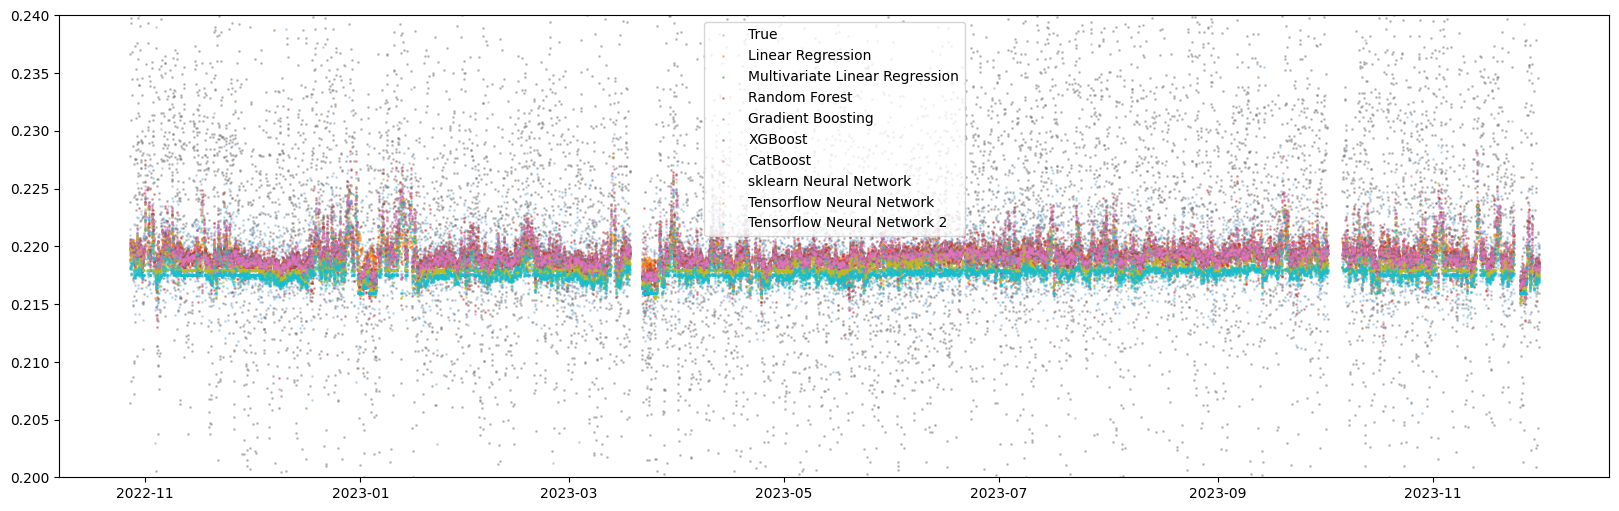

In [129]:
print('Linear Regression', 'MSE: '+str(mean_squared_error(y_test, lin_regr_pred)), 'R2: '+str(r2_score(y_test, lin_regr_pred)))
#print('Multivariate Linear Regression', 'MSE: '+str(mean_squared_error(y_test.loc[mult_lin_regr_pred.index], mult_lin_regr_pred)), 'R2: '+str(r2_score(y_test.loc[mult_lin_regr_pred.index], mult_lin_regr_pred)))
print('Random Forest Regression', 'MSE: '+str(mean_squared_error(y_test, rf_regr_pred)), 'R2: '+str(r2_score(y_test, rf_regr_pred)))
print('Gradient Boosting Regression', 'MSE: '+str(mean_squared_error(y_test, gb_regr_pred)), 'R2: '+str(r2_score(y_test, gb_regr_pred)))
print('XGBoost Regression', 'MSE: '+str(mean_squared_error(y_test, xgb_regr_pred)), 'R2: '+str(r2_score(y_test, xgb_regr_pred)))
print('CatBoost Regression', 'MSE: '+str(mean_squared_error(y_test, cat_regr_pred)), 'R2: '+str(r2_score(y_test, cat_regr_pred)))
print('MLP Regression', 'MSE: '+str(mean_squared_error(y_test, mlp_regr_pred)), 'R2: '+str(r2_score(y_test, mlp_regr_pred)))
print('Neural Network Regression', 'MSE: '+str(mean_squared_error(y_test, nn_regr_pred)), 'R2: '+str(r2_score(y_test, nn_regr_pred)))
print('Neural Network Regression 2', 'MSE: '+str(mean_squared_error(y_test, nn_regr_2_pred)), 'R2: '+str(r2_score(y_test, nn_regr_2_pred)))

plt.figure(figsize=(20,6))
plt.scatter(y_test.index, y_test, s=1, alpha=0.2, label='True')
plt.scatter(lin_regr_pred.index, lin_regr_pred['predictions'], s=1, alpha=0.4, label='Linear Regression')
plt.scatter(mult_lin_regr_pred.index, mult_lin_regr_pred['predictions'], s=1, alpha=0.4, label='Multivariate Linear Regression')
plt.scatter(rf_regr_pred.index, rf_regr_pred['predictions'], s=1, alpha=0.4, label='Random Forest')
plt.scatter(gb_regr_pred.index, gb_regr_pred['predictions'], s=1, alpha=0.4, label='Gradient Boosting')
plt.scatter(xgb_regr_pred.index, xgb_regr_pred['predictions'], s=1, alpha=0.4, label='XGBoost')
plt.scatter(cat_regr_pred.index, cat_regr_pred['predictions'], s=1, alpha=0.4, label='CatBoost')
plt.scatter(mlp_regr_pred.index, mlp_regr_pred['predictions'], s=1, alpha=0.4, label='sklearn Neural Network')
plt.scatter(nn_regr_pred.index, nn_regr_pred['predictions'], s=1, alpha=0.4, label='Tensorflow Neural Network')
plt.scatter(nn_regr_2_pred.index, nn_regr_2_pred['predictions'], s=1, alpha=0.4, label='Tensorflow Neural Network 2')
plt.legend()
plt.ylim([0.2, 0.24])
plt.show()
plt.close()

# Hyperparameter Optimize

In [9]:
#Hyperparameter optimization: Bayesian optimization
#Hyperopt functions for hyperparameter optimizations
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from src.models.utils import convert_dict
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import numpy as np
XGB_optimizations = {}
mode = 'SS1'

seed = 42
def objective_xgb(space):
    model = XGBRegressor(
                                 n_estimators = space['n_estimators'],
                                 max_depth = space['max_depth'],
                                 learning_rate = space['learning_rate'],
                                 colsample_bytree = space['colsample_bytree'],
                                 )
    score = cross_val_score(model,  X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    # We aim to minimize mse 
    return {'loss': -score, 'status': STATUS_OK }
def optimize_xgb(trial):
    space = {
        'n_estimators':hp.uniformint('n_estimators',10,500),
        'max_depth':hp.uniformint('max_depth',2,20),
        'learning_rate':hp.uniform('learning_rate',0.001,0.5),
        'colsample_bytree': hp.uniform('colsample_bytree',0.1, 1),
    }
    best = \
        fmin(
            fn = objective_xgb,
            space = space,
            algo = tpe.suggest,
            trials = trial,
            max_evals = 50,
            rstate = np.random.RandomState(seed)
            )
    return best
trial2=Trials()
XGB_optimizations[mode] = optimize_xgb(trial2)
XGB_optimizations[mode] = convert_dict(XGB_optimizations)[mode]

100%|██████████| 50/50 [13:21<00:00, 16.03s/trial, best loss: 8.519414076258715e-06] 


NameError: name 'XGB_optimization' is not defined

In [13]:
XGB_optimize = XGB_optimizations[mode]
regr_xgb_optimized = \
    XGBRegressor(
        n_estimators = XGB_optimize['n_estimators'],
        max_depth = XGB_optimize['max_depth'],
        learning_rate = XGB_optimize['learning_rate'],
        colsample_bytree = XGB_optimize['colsample_bytree'],
        )
regr_xgb_optimized.fit(X_train, y_train)

regr_xgb_optimized_pred = regr_xgb_optimized.predict(X_test)
regr_xgb_optimized_mse = mean_squared_error(y_test, regr_xgb_optimized_pred)
regr_xgb_optimized_r2 = r2_score(y_test, regr_xgb_optimized_pred)
print("XGBRegressor Optimized MSE:", regr_xgb_optimized_mse, "XGBRegressor Optimized R2:", regr_xgb_optimized_r2)

XGBRegressor Optimized MSE: 8.352706510195964e-06 XGBRegressor Optimized R2: 0.1043337985359094


In [14]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

def objective_catboost(space):
    model = CatBoostRegressor(
        iterations=int(space['iterations']),
        depth=int(space['depth']),
        learning_rate=space['learning_rate'],
        l2_leaf_reg=space['l2_leaf_reg'],
        border_count=int(space['border_count']),
        random_strength=space['random_strength'],
        bagging_temperature=space['bagging_temperature'],
        verbose=False  # to make CatBoost quiet
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    return {'loss': -score, 'status': STATUS_OK}

def optimize_catboost(trial):
    space = {
        'iterations': hp.uniformint('iterations', 100, 1000),
        'depth': hp.uniformint('depth', 2, 16),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
        'border_count': hp.uniformint('border_count', 32, 255),
        'random_strength': hp.uniform('random_strength', 0, 20),
        'bagging_temperature': hp.uniform('bagging_temperature', 0, 1)
    }
    best = fmin(
        fn=objective_catboost,
        space=space,
        algo=tpe.suggest,
        trials=trial,
        max_evals=50,
        rstate=np.random.RandomState(seed)
    )
    return best

# Example usage
trial_catboost = Trials()
CatBoost_optimizations = optimize_catboost(trial_catboost)
CatBoost_optimizations = convert_dict(CatBoost_optimizations)
print(CatBoost_optimizations)

# Creating and training the optimized CatBoostRegressor
regr_catboost_optimized = CatBoostRegressor(
    **CatBoost_optimizations,
    verbose=False
)
regr_catboost_optimized.fit(X_train, y_train)

# Prediction and evaluation
regr_catboost_optimized_pred = regr_catboost_optimized.predict(X_test)
regr_catboost_optimized_mse = mean_squared_error(y_test, regr_catboost_optimized_pred)
regr_catboost_optimized_r2 = r2_score(y_test, regr_catboost_optimized_pred)
print("CatBoostRegressor Optimized MSE:", regr_catboost_optimized_mse, "CatBoostRegressor Optimized R2:", regr_catboost_optimized_r2)


100%|██████████| 50/50 [6:11:41<00:00, 446.02s/trial, best loss: 8.505716963105146e-06]    


AttributeError: 'numpy.float64' object has no attribute 'items'

In [15]:
CatBoost_optimizations

{'bagging_temperature': 0.0024210148458735647,
 'border_count': 148.0,
 'depth': 9.0,
 'iterations': 404.0,
 'l2_leaf_reg': 9.678586732885769,
 'learning_rate': 0.027465163258532488,
 'random_strength': 13.235228781449614}

In [17]:
CatBoost_optimizations_dict = {}
CatBoost_optimizations_dict[mode] = CatBoost_optimizations

In [18]:
CatBoost_optimizations = convert_dict(CatBoost_optimizations_dict)[mode]
print(CatBoost_optimizations)

# Creating and training the optimized CatBoostRegressor
regr_catboost_optimized = CatBoostRegressor(
    **CatBoost_optimizations,
    verbose=False
)
regr_catboost_optimized.fit(X_train, y_train)

# Prediction and evaluation
regr_catboost_optimized_pred = regr_catboost_optimized.predict(X_test)
regr_catboost_optimized_mse = mean_squared_error(y_test, regr_catboost_optimized_pred)
regr_catboost_optimized_r2 = r2_score(y_test, regr_catboost_optimized_pred)
print("CatBoostRegressor Optimized MSE:", regr_catboost_optimized_mse, "CatBoostRegressor Optimized R2:", regr_catboost_optimized_r2)


{'bagging_temperature': 0.0024210148458735647, 'border_count': 148, 'depth': 9, 'iterations': 404, 'l2_leaf_reg': 9.678586732885769, 'learning_rate': 0.027465163258532488, 'random_strength': 13.235228781449614}
CatBoostRegressor Optimized MSE: 8.340713102589764e-06 CatBoostRegressor Optimized R2: 0.10561985950550568


In [ ]:
from src.models.learning_rate import *

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import numpy as np
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

def create_model(hidden_layers, units, batch_normalization):
    model = Sequential()
    model.add(Dense(units[0], input_dim=X_train.shape[1], activation='relu'))
    if batch_normalization:
        model.add(BatchNormalization())

    for i in range(1, hidden_layers):
        model.add(Dense(units[i], activation='relu'))
        if batch_normalization:
            model.add(BatchNormalization())

    model.add(Dense(1, activation='linear'))  # Assuming a regression problem
    return model

def objective(params):
    model = create_model(params['hidden_layers'], [params['units_1'], params['units_2'], params['units_3']], params['batch_normalization'])
    # Learning rate schedulers
    if params['lr_schedule'] == 'linear':
        lr_scheduler = LinearLearningRateScheduler(params['start_lr'], params['end_lr'], 100)
    elif params['lr_schedule'] == 'sinusoidal':
        lr_scheduler = SinusoidalLearningRateScheduler(params['base_lr'], params['max_lr'], 100)
        
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stop], verbose=0)

    score = model.evaluate(X_test, y_test, verbose=0)
    return {'loss': score, 'status': STATUS_OK}

def optimize(hidden_layers):
    space = {
        'hidden_layers': hidden_layers,
        'units_1': hp.uniform('units_1', 32, 256),
        'units_2': hp.uniform('units_2', 32, 256) if hidden_layers > 1 else None,
        'units_3': hp.uniform('units_3', 32, 256) if hidden_layers > 2 else None,
        'batch_normalization': hp.choice('batch_normalization', [False, True]),
        'learning_rate': hp.uniform('learning_rate', 0.0001, 0.01),
        'lr_schedule': hp.choice('lr_schedule', ['constant', 'linear', 'sinusoidal']),
        'start_lr': hp.uniform('start_lr', 0.0001, 0.01),
        'end_lr': hp.uniform('end_lr', 0.0001, 0.01),
        'base_lr': hp.uniform('base_lr', 0.0001, 0.01),
        'max_lr': hp.uniform('max_lr', 0.0001, 0.01),
    }
    trials = Trials()
    best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)
    return best


In [ ]:
best_hyperparams_1_layer = optimize(1)
print("Best Hyperparameters for 1 layer:", best_hyperparams_1_layer)

In [ ]:
best_hyperparams_2_layers = optimize(2)
print("Best Hyperparameters for 2 layers:", best_hyperparams_2_layers)

In [ ]:
best_hyperparams_3_layers = optimize(3)
print("Best Hyperparameters for 3 layers:", best_hyperparams_3_layers)

In [ ]:
from src.models.learning_rate import *
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import numpy as np

def create_model(params):
    model = Sequential()
    model.add(Dense(params['units_1'], input_dim=X_train.shape[1], activation='relu'))
    if params['batch_normalization']:
        model.add(BatchNormalization())
    for i in range(1, params['hidden_layers']):
        model.add(Dense(params['units_' + str(i + 1)], activation='relu'))
        if params['batch_normalization']:
            model.add(BatchNormalization())

    model.add(Dense(1, activation='linear'))  # Assuming a regression problem
    return model

def objective(params):
    model = create_model(params)

    # Learning rate schedulers
    if params['lr_schedule'] == 'linear':
        lr_scheduler = LinearLearningRateScheduler(params['start_lr'], params['end_lr'], 100)
    elif params['lr_schedule'] == 'sinusoidal':
        lr_scheduler = SinusoidalLearningRateScheduler(params['base_lr'], params['max_lr'], 100)

    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stop, lr_scheduler], verbose=0)

    score = model.evaluate(X_test, y_test, verbose=0)
    return {'loss': score, 'status': STATUS_OK}

def optimize():
    space = {
        'hidden_layers': hp.choice('hidden_layers', [1, 2, 3]),
        'units_1': hp.uniform('units_1', 32, 256),
        'units_2': hp.uniform('units_2', 32, 256),
        'units_3': hp.uniform('units_3', 32, 256),
        'batch_normalization': hp.choice('batch_normalization', [False, True]),
        'learning_rate': hp.uniform('learning_rate', 0.0001, 0.01),
        'lr_schedule': hp.choice('lr_schedule', ['constant', 'linear', 'sinusoidal']),
        'start_lr': hp.uniform('start_lr', 0.0001, 0.01),
        'end_lr': hp.uniform('end_lr', 0.0001, 0.01),
        'base_lr': hp.uniform('base_lr', 0.0001, 0.01),
        'max_lr': hp.uniform('max_lr', 0.0001, 0.01),
    }
    trials = Trials()
    best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)
    return best

best_hyperparams = optimize()
print(best_hyperparams)
